In [2]:
# set auto-reload of the notebook
%load_ext autoreload
%autoreload 2

import cns
import cns.data_utils as cdu
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
# set color_map to tab10
color_map = plt.cm.get_cmap('tab10').colors[:10]
plt.rcParams.update({'font.size': 12})

C:\Users\adams\AppData\Local\Temp\ipykernel_38604\1736925853.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10').colors[:10]


In [3]:
cns_dfs = {}
for grouping in ["whole", "arms", "20MB", "5MB", "1MB"]:
	print(f"Loading {grouping}...")
	samples_df, cns_df = cdu.main_load(grouping)
	cns.only_aut(cns_df, inplace=True)
	cns.add_total_cn(cns_df, inplace=True)
	cns_dfs[grouping] = cns_df
samples_df["type"].value_counts().head()

Loading whole...
Loading arms...
Loading 20MB...
Loading 5MB...
Loading 1MB...


type
LUAD    1314
BRCA    1157
LUSC     996
OV       618
PRAD     563
Name: count, dtype: int64

In [8]:
cosmic = cdu.load_COSMIC()
cosmic_df = cns.segments_to_cns_df(cosmic)[["chrom", "start", "end", "name"]].rename(columns={"name": "gene"})
ensembl = cdu.load_ENSEMBL()
cancer_type = "LUSC"
val_count = 3

In [9]:
def get_grouping_name(grouping):
    if grouping == "whole":
        return "Whole genome"
    elif grouping == "arms":
        return "Chromosomal arms"
    elif grouping.upper().endswith("MB") or grouping.upper().endswith("KB"):
        # Extract number and unit
        try:
            number = int(grouping[:-2])
            unit = grouping[-2:].upper()
            return f"{number} {unit.capitalize()} bins"
        except ValueError:
            pass  # Fall through to error
    raise ValueError(f"Unknown grouping: {grouping}")

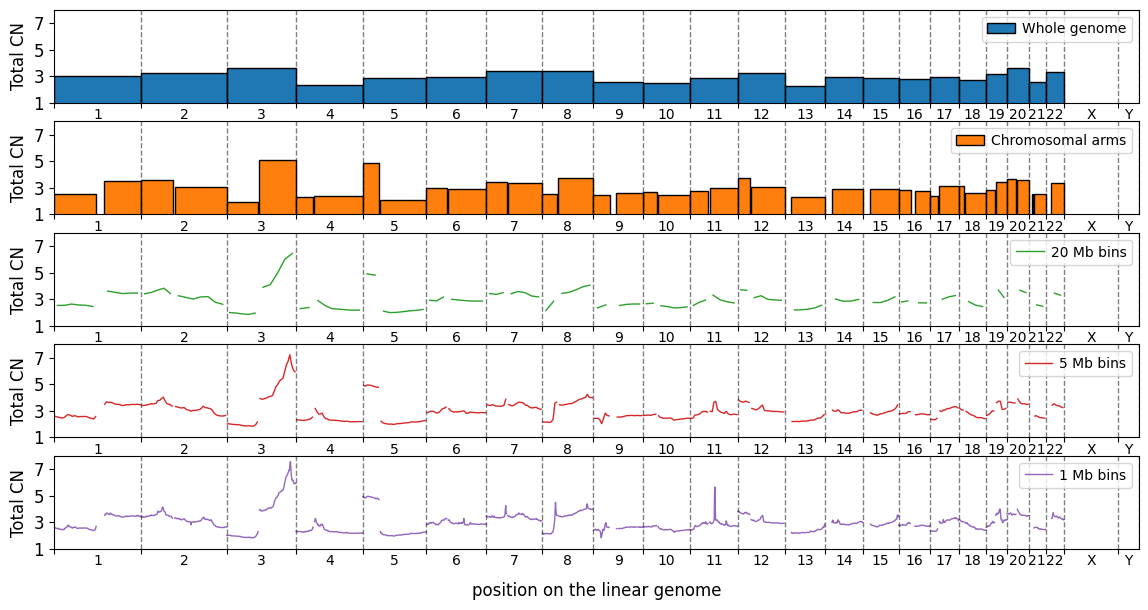

In [16]:
fig, axs = plt.subplots(len(cns_dfs), 1, figsize=(14, 7))

for i, (grouping, cns_df) in enumerate(cns_dfs.items()):
	sel_df = cns.select_cns_by_type(cns_df, samples_df, cancer_type) if cancer_type != "all" else cns_df
	group_df = cns.group_samples(cns.only_aut(cns.add_total_cn(sel_df)))
	group_df["sample_id"] = f"mean {cancer_type} CN"
	group_df = cns.add_cum_mid(group_df)
	if grouping == "whole":
		group_by = "sample"
	elif grouping == "arms":
		group_by = "chrom"
	else:
		group_by = "cons"
	group_df["score"] = cns.calc_angles(group_df, "total_cn", group_by=group_by)

	if grouping == "whole" or grouping == "arms":

		cns.plot_bars(axs[i], group_df, cn_column="total_cn", color=color_map[i], label=f"{get_grouping_name(grouping)}")
	else:
		cns.plot_lines(axs[i], group_df, cn_column="total_cn", color=color_map[i],  label=f"{get_grouping_name(grouping)}")
	cns.plot_x_lines(axs[i])
	cns.plot_x_ticks(axs[i])

	group_df = group_df.sort_values(by="score", ascending=False)
	# axs[i].scatter(group_df["cum_mid"].head(val_count), group_df["total_cn"].head(val_count), color="k", alpha=0.75, s=35, label=f"Top {val_count} peaks", marker="+")
	# axs[i].scatter(group_df["cum_mid"].tail(val_count), group_df["total_cn"].tail(val_count), color="k", alpha=0.75, s=35, label=f"Top {val_count} valleys", marker="x")
	axs[i].set_ylim(1, 8)
	axs[i].set_yticks([1, 3, 5, 7])
	axs[i].set_ylabel("Total CN")
	axs[i].legend(loc="upper right", ncol=3, fontsize=10, handletextpad=0.5, columnspacing=1)

axs[-1].set_xlabel("position on the linear genome")

cdu.save_cns_fig(f"fig_peaks_valleys_{cancer_type}")